## Image segmentation with CamVid

In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [45]:
path = untar_data(URLs.CAMVID, dest=Path().home()/'programming/data')
path.ls()

[PosixPath('/home/neronicolo/programming/data/camvid/images'),
 PosixPath('/home/neronicolo/programming/data/camvid/valid.txt'),
 PosixPath('/home/neronicolo/programming/data/camvid/codes.txt'),
 PosixPath('/home/neronicolo/programming/data/camvid/labels')]

In [46]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [47]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [48]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/neronicolo/programming/data/camvid/images/0016E5_05010.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/images/0006R0_f03600.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/images/0016E5_05460.png')]

In [49]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/neronicolo/programming/data/camvid/labels/Seq05VD_f04650_P.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/labels/0016E5_07989_P.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/labels/0001TP_010320_P.png')]

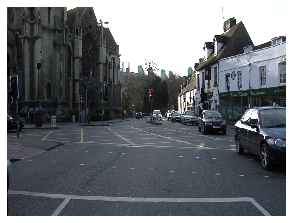

In [50]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [51]:
f'{fnames[0]}'

'/home/neronicolo/programming/data/camvid/images/0016E5_05010.png'

In [52]:
f'{fnames[0].stem}'

'0016E5_05010'

In [53]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
get_y_fn(fnames[0])

PosixPath('/home/neronicolo/programming/data/camvid/labels/0016E5_05010_P.png')

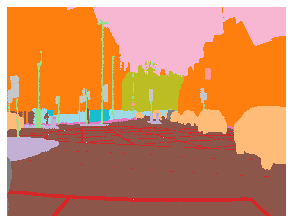

In [54]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [55]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [56]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [57]:
l = [26, 21, 18]

In [58]:
codes[l]

array(['Tree', 'Sky', 'RoadShoulder'], dtype='<U17')

## Datasets

In [1]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

NameError: name 'src_size' is not defined

In [60]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [61]:
valid_txt = open(path/'valid.txt', 'r')
l = valid_txt.read().split()

l[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [62]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [71]:
data.show_batch(2, figsize=(10,7))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.94 GiB total capacity; 2.99 GiB already allocated; 12.69 MiB free; 3.02 GiB reserved in total by PyTorch)

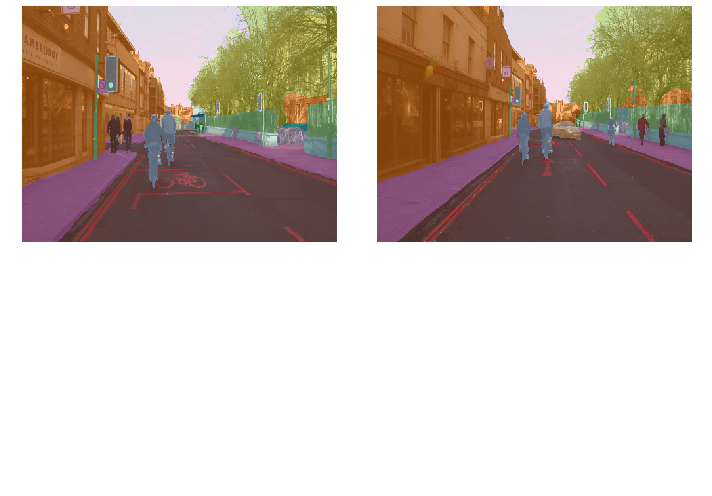

In [64]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [65]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [66]:
{v:k for k,v in enumerate(codes)}

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [67]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [68]:
metrics=acc_camvid
# metrics=accuracy

In [69]:
wd=1e-2

In [70]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.94 GiB total capacity; 2.99 GiB already allocated; 13.19 MiB free; 3.02 GiB reserved in total by PyTorch)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(10,12))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find(start_lr=1e-09, end_lr=1e-02)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-07,1e-05)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
learn.load('stage-2');

In [ ]:
learn.show_results(rows=3, figsize=(10,12))

## Go big

#### Increasing image to original size

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin